In [1]:
import ipyparallel as ipp
def mpi_example():
    comm = MPI.COMM_WORLD
    return f"Hello World from rank {comm.Get_rank()}. total ranks={comm.Get_size()}"

with ipp.Cluster(engines='mpi', n=8) as rc:
    # get a broadcast_view on the cluster which is best
    # suited for MPI style computation
    view = rc.broadcast_view()
    # run the mpi_example function on all engines in parallel
    r = view.apply_sync(mpi_example)
    # Retrieve and print t

Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/8 [00:00<?, ?engine/s]

Stopping engine(s): 1728771192
engine set stopped 1728771192: {'exit_code': 0, 'pid': 3482, 'identifier': 'ipengine-1728771191-h8j2-1728771192-3434'}
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 3451, 'identifier': 'ipcontroller-1728771191-h8j2-3434'}


In [12]:
from mpi4py import MPI
from petsc4py import PETSc
import matplotlib.pyplot as plt
import numpy as np
import pyvista
import gmsh

from dolfinx import geometry
from dolfinx.fem import Constant, Function, functionspace, assemble_scalar, dirichletbc, form, locate_dofs_geometrical, locate_dofs_topological
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
from dolfinx.io import VTXWriter, gmshio
from dolfinx.mesh import create_unit_square,create_rectangle,CellType
from dolfinx.plot import vtk_mesh
from basix.ufl import element
from ufl import (FacetNormal, Identity, TestFunction, TrialFunction,Measure,
                 div, dot, ds, dx, inner, lhs, nabla_grad, rhs, sym,
                 SpatialCoordinate, conditional, ge, le)

In [36]:
def run_sim(height=.5, length=3,T=3,num_steps=4000, file=False):
    # mesh = create_rectangle(MPI.COMM_WORLD,[[0,0], [length, height]],[int(length*25),int(height*25)])
    # mesh = create_unit_square(MPI.COMM_WORLD, 100, 100)
    mesh, ft, inlet_marker,outlet_marker, obstacle_marker, wall_marker = create_obst(height, length)
    t = 0
    dt = T / num_steps
    pres = 100 ## pressure
    
    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    fdim = mesh.topology.dim - 1
    
    # Define boundary conditions
    
    
    class InletVelocity():
        def __init__(self, t):
            self.t = t
            self.dtype = dtype=PETSc.ScalarType
    
        def __call__(self, x):
            values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
            values[0] = PETSc.ScalarType(press)
            return values
    
    
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(t)
    #u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(inlet_velocity, locate_dofs_topological(V, fdim, ft.find(inlet_marker)))
    # Walls
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bcu_walls = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V)
    # Obstacle
    bcu_obstacle = dirichletbc(u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V)
    bcu = [bcu_obstacle, bcu_walls]
    # Outlet
    bcp_outlet = dirichletbc(PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q)
    bcp = [bcu_inflow, bcp_outlet]
    '''
    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim, ))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)
    
    u = TrialFunction(V)
    v = TestFunction(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    
    def walls(x):
        return np.logical_or(np.isclose(x[1], 0), np.isclose(x[1], height))
    
    wall_dofs = locate_dofs_geometrical(V, walls)
    u_noslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    bc_noslip = dirichletbc(u_noslip, wall_dofs, V)
    
    def inflow(x):
        return np.isclose(x[0], 0)
    
    inflow_dofs = locate_dofs_geometrical(Q, inflow)
    bc_inflow = dirichletbc(PETSc.ScalarType(pres), inflow_dofs, Q)
    
    def outflow(x):
        return np.isclose(x[0], length)
    
    outflow_dofs = locate_dofs_geometrical(Q, outflow)
    bc_outflow = dirichletbc(PETSc.ScalarType(0), outflow_dofs, Q)
    bcu = [bc_noslip]
    bcp = [bc_inflow, bc_outflow]'''
    
    u_n = Function(V)
    u_n.name = "u_n"
    U = 0.5 * (u_n + u)
    n = FacetNormal(mesh)
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(1))
    rho = Constant(mesh, PETSc.ScalarType(1))
    
    # Define strain-rate tensor
    def epsilon(u):
        return sym(nabla_grad(u))
    
    # Define stress tensor
    def sigma(u, p):
        return 2 * mu * epsilon(u) - p * Identity(len(u))
    
    
    # Define the variational problem for the first step
    p_n = Function(Q)
    p_n.name = "p_n"
    F1 = rho * dot((u - u_n) / k, v) * dx
    F1 += rho * dot(dot(u_n, nabla_grad(u_n)), v) * dx
    F1 += inner(sigma(U, p_n), epsilon(v)) * dx
    F1 += dot(p_n * n, v) * ds - dot(mu * nabla_grad(U) * n, v) * ds
    F1 -= dot(f, v) * dx
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    
    
    A1 = assemble_matrix(a1, bcs=bcu)
    A1.assemble()
    b1 = create_vector(L1)
    
    # Define variational problem for step 2
    u_ = Function(V)
    a2 = form(dot(nabla_grad(p), nabla_grad(q)) * dx)
    L2 = form(dot(nabla_grad(p_n), nabla_grad(q)) * dx - (rho / k) * div(u_) * q * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)
    
    # Define variational problem for step 3
    p_ = Function(Q)
    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_, v) * dx - k * dot(nabla_grad(p_ - p_n), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)
    
    # Solver for step 1
    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.BCGS)
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.HYPRE)
    pc1.setHYPREType("boomeramg")
    
    # Solver for step 2
    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.BCGS)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.HYPRE)
    pc2.setHYPREType("boomeramg")
    
    # Solver for step 3
    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.CG)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.SOR)

    if file:
        from pathlib import Path
        folder = Path("results")
        folder.mkdir(exist_ok=True, parents=True)
        vtx_u = VTXWriter(mesh.comm, folder / "poiseuille_u.bp", u_n, engine="BP4")
        vtx_p = VTXWriter(mesh.comm, folder / "poiseuille_p.bp", p_n, engine="BP4")
        vtx_u.write(t)
        vtx_p.write(t)
    
    def u_exact(x):
        values = np.zeros((2, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = 4 * x[1] * (1.0 - x[1])
        return values
    
    u_ex = Function(V)
    u_ex.interpolate(u_exact)
    
    L2_error = form(dot(u_ - u_ex, u_ - u_ex) * dx)

    fig, ax = plt.subplots()
    plt.xlabel('y')
    plt.ylabel('u_n')
    plt.title('u_n values at different x-coordinates')
    
    for i in range(num_steps):
        # Update current time step
        t += dt
    
        # Step 1: Tentative veolcity step
        with b1.localForm() as loc_1:
            loc_1.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_.x.petsc_vec)
        u_.x.scatter_forward()
    
        # Step 2: Pressure corrrection step
        with b2.localForm() as loc_2:
            loc_2.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, p_.x.petsc_vec)
        p_.x.scatter_forward()
    
        # Step 3: Velocity correction step
        with b3.localForm() as loc_3:
            loc_3.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()
        # Update variable with solution form this time step
        u_n.x.array[:] = u_.x.array[:]
        p_n.x.array[:] = p_.x.array[:]
    
        # print velocity profile
        if (i % 500 == 0) or (i == num_steps - 1):
            plot_para_velo(ax,mesh, u_n, p_n, t, length)
            a6, a7 = mfl_press(length, mesh, u_n, p_n)
            print(a6, a7)
            pass

        if file:
            # Write solutions to file
            vtx_u.write(t)
            vtx_p.write(t)
    
        # Compute error at current time-step
        error_L2 = np.sqrt(mesh.comm.allreduce(assemble_scalar(L2_error), op=MPI.SUM))
        error_max = mesh.comm.allreduce(np.max(u_.x.petsc_vec.array - u_ex.x.petsc_vec.array), op=MPI.MAX)
        # Print error only every 20th step and at the last step
        if (i % 20 == 0) or (i == num_steps - 1):
            print(f"Time {t:.2f}, L2-error {error_L2:.2e}, Max error {error_max:.2e}")
    # Close xmdf file
    if file:
        vtx_u.close()
        vtx_p.close()
    b1.destroy()
    b2.destroy()
    b3.destroy()
    solver1.destroy()
    solver2.destroy()
    solver3.destroy()
    return u_n, p_n, V, mesh

In [38]:
u_n, p_n, V, mesh = run_sim()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Ellipse)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Line)
Info    : [ 90%] Meshing curve 6 (Line)
Info    : Done meshing 1D (Wall 0.00090361s, CPU 0.001321s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay for Quads)
Info    : Simple recombination completed (Wall 3.5519e-05s, CPU 3.7e-05s): 2 quads, 1 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.5, min Q = 0.5
Info    : Simple recombination completed (Wall 0.000559053s, CPU 0.000601s): 11 quads, 0 triangles, 0 invalid quads, 1 quads with Q < 0.1, avg Q = 0.375329, min Q = 0.0596378
Info    : Done meshing 2D (Wall 0.000940459s, CPU 0.001026s)
Info    : Refining mesh...
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 30%] Meshing curve 3 

TypeError: __init__(): incompatible function arguments. The following argument types are supported:
    1. __init__(self, g: ndarray[dtype=float64, writable=False, order='C'], dofs: ndarray[dtype=int32, writable=False, shape=(*), order='C'], V: dolfinx.cpp.fem.FunctionSpace_float64) -> None
    2. __init__(self, g: dolfinx.cpp.fem.Constant_float64, dofs: ndarray[dtype=int32, writable=False, shape=(*), order='C'], V: dolfinx.cpp.fem.FunctionSpace_float64) -> None
    3. __init__(self, g: dolfinx.cpp.fem.Function_float64, dofs: ndarray[dtype=int32, writable=False, shape=(*), order='C']) -> None
    4. __init__(self, g: dolfinx.cpp.fem.Function_float64, dofs: list[ndarray[dtype=int32, writable=False, shape=(*), order='C']], V: dolfinx.cpp.fem.FunctionSpace_float64) -> None

Invoked with types: dolfinx.cpp.fem.DirichletBC_float64, __main__.InletVelocity, ndarray

In [37]:
gmsh.clear()

Info    : Clearing all models and views...
Info    : Done clearing all models and views


In [4]:
# Get the minimum and maximum x-coordinates of the mesh
def mfl_press(x_max, mesh, u_n, p):
    # Extract the normal component of velocity (u_x in 2D)
    u_sub = u_n.sub(0)
    
    # Define measures and spatial coordinates
    dx = Measure("dx", domain=mesh)
    x = SpatialCoordinate(mesh)
    x_pos = int(x_max/2)

    slice_condition = conditional(ge(x[0], x_pos - 5e-1), 1.0, 0.0) * conditional(le(x[0], x_pos + 5e-1), 1.0, 0.0)
    # Calculate mass flow rate at the current slice
    mass_flow = assemble_scalar(form(u_sub * slice_condition * dx))
    # Calculate average pressure at the current slice
    pressure_avg = assemble_scalar(form(p * slice_condition * dx)) / assemble_scalar(form(slice_condition * dx))
        
    return mass_flow, pressure_avg

In [5]:
def plot_para_velo(ax,mesh, u_n,p_n, t, length):
    if MPI.COMM_WORLD.rank == 0:
        tol = 0.001  # Avoid hitting the outside of the domain
        y = np.linspace(0+tol, length-tol, int(length*100))
        points = np.zeros((3, int(length*100)))
        points[1] = y
        
        bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
        cells, points_on_proc = [], []
        # Find cells whose bounding-box collide with the the points
        cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
        # Choose one of the cells that contains the point
        colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i)) > 0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        
        points_on_proc = np.array(points_on_proc, dtype=np.float64)
        u_values = u_n.eval(points_on_proc, cells)
        p_values = p_n.eval(points_on_proc, cells)
        plt.plot(points_on_proc[:, 1], u_values[:,0], "k", linewidth=2, label="Velocity over x-Axis")
        #plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth=2, label="Pressure")
        plt.xlabel("x")
        plt.ylabel("Velocity u")
        # If run in parallel as a python file, we save a plot per processor
        plt.savefig(f"para_plot/u_n_p_{int(t*100):d}.pdf")

In [20]:
def create_obst(H, L, r=.3 ):
    gdim = 2
    comm = MPI.COMM_WORLD
    inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
    inflow, outflow, walls, obstacle = [], [], [], []
    
    fluid_marker = 1
    model_rank = 0
    gmsh.initialize()
    if comm.rank == model_rank:
        rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)
        obs = gmsh.model.occ.addDisk(H, H, 0, r, r)
        fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obs)])
        gmsh.model.occ.synchronize()
        volumes = gmsh.model.getEntities(dim=gdim)
        assert (len(volumes) == 1)
        gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
        gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")
        # boundaries
        boundaries = gmsh.model.getBoundary(volumes, oriented=False)
        for boundary in boundaries:
            center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
            if np.allclose(center_of_mass, [0, H / 2, 0]):
                inflow.append(boundary[1])
            elif np.allclose(center_of_mass, [L, H / 2, 0]):
                outflow.append(boundary[1])
            elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(center_of_mass, [L / 2, 0, 0]):
                walls.append(boundary[1])
            else:
                obstacle.append(boundary[1])
        gmsh.model.addPhysicalGroup(1, walls, wall_marker)
        gmsh.model.setPhysicalName(1, wall_marker, "Walls")
        gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
        gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
        gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
        gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
        gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
        gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")
        # from https://gitlab.onelab.info/gmsh/gmsh/blob/gmsh_4_13_1/tutorials/python/t7.py
        bg_field = gmsh.model.mesh.field.add("PostView")
        gmsh.model.mesh.field.setNumber(bg_field, "ViewIndex", 0)
        gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
        gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
        
        gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
        gmsh.option.setNumber("Mesh.Algorithm", 8)
        gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 2)
        gmsh.option.setNumber("Mesh.RecombineAll", 1)
        gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 1)
        gmsh.model.mesh.generate(gdim)
        gmsh.model.mesh.setOrder(2)
        gmsh.model.mesh.optimize("Netgen")
        mesh, _, ft = gmshio.model_to_mesh(gmsh.model, comm, model_rank, gdim=2)
        return mesh, ft, inlet_marker, outlet_marker, obstacle_marker, wall_marker

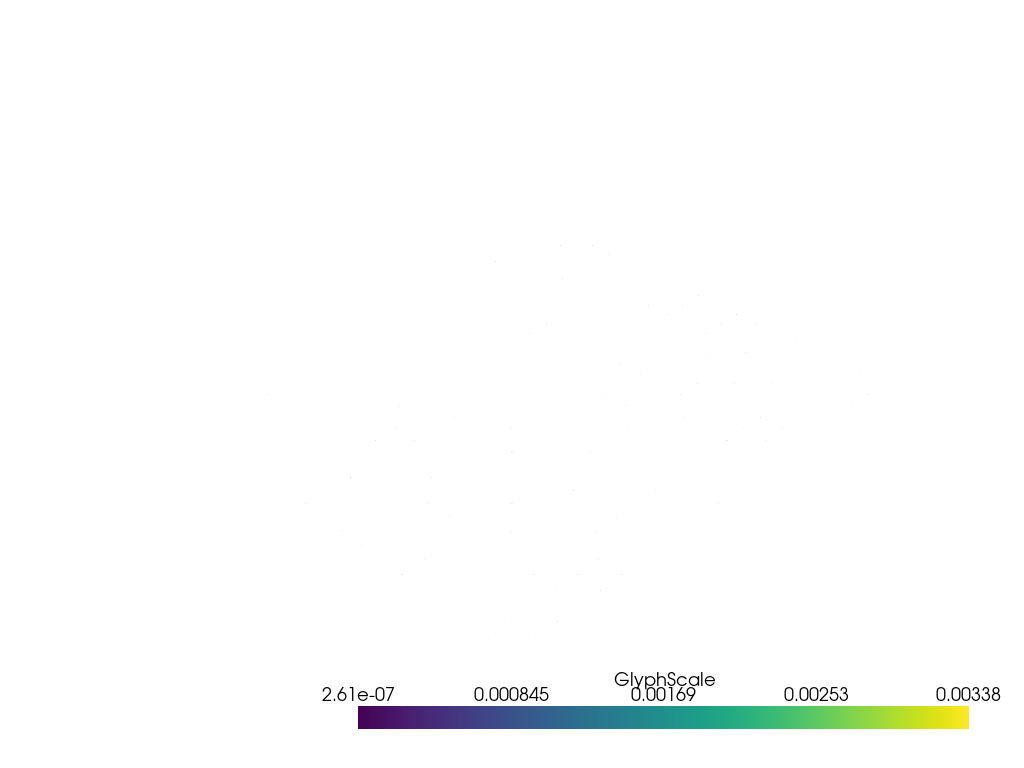

In [56]:
import pyvista
pyvista.start_xvfb()
topology, cell_types, geometry = vtk_mesh(V)
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geometry.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.7)

# Create a pyvista-grid for the mesh
#mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
#grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
#plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
#plotter.window_size = [800, 600]
#plotter.set_scale(yscale=4)
#plotter.view_xy()
plotter.save_graphic("glyphs2.pdf",title='PyVista Export')
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("velocity_field.pdf")

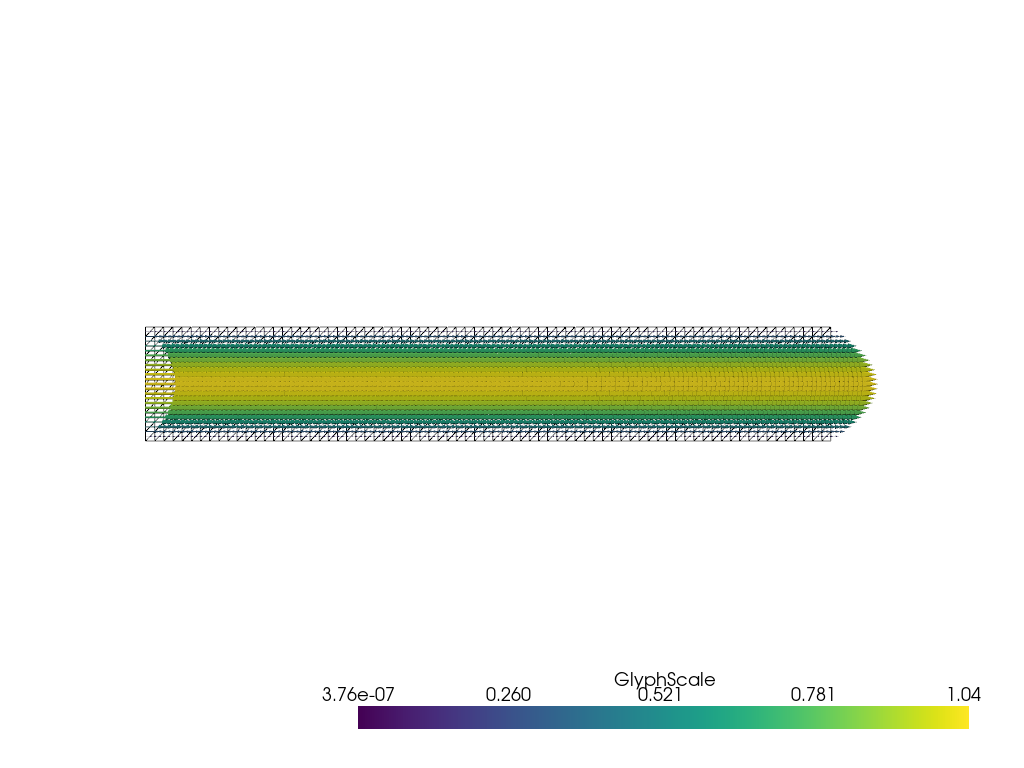

In [90]:
pyvista.start_xvfb()
topology, cell_types, geo = vtk_mesh(V)
values = np.zeros((geo.shape[0], 3), dtype=np.float64)
values[:, :len(u_n)] = u_n.x.array.real.reshape((geo.shape[0], len(u_n)))

# Create a point cloud of glyphs
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geo)
function_grid["u"] = values
glyphs = function_grid.glyph(orient="u", factor=0.2)

# Create a pyvista-grid for the mesh
grid = pyvista.UnstructuredGrid(*vtk_mesh(mesh, mesh.topology.dim))

# Create plotter
plotter = pyvista.Plotter()
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
    plotter.screenshot("canal.png")
else:
    fig_as_array = plotter.screenshot("glyphs.png")

In [ ]:
t = .8
tol = 0.001  # Avoid hitting the outside of the domain
y = np.linspace(0+tol, 1-tol, 101)
points = np.zeros((3, 101))
points[1] = y

bb_tree = geometry.bb_tree(mesh, mesh.topology.dim)
cells, points_on_proc = [], []
# Find cells whose bounding-box collide with the the points
cell_candidates = geometry.compute_collisions_points(bb_tree, points.T)
# Choose one of the cells that contains the point
colliding_cells = geometry.compute_colliding_cells(mesh, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u_n.eval(points_on_proc, cells)
p_values = p_n.eval(points_on_proc, cells)
plt.plot(points_on_proc[:, 1], u_values[:,0], "k", linewidth=2, label="Velocity over x-Axis")
#plt.plot(points_on_proc[:, 1], p_values, "b--", linewidth=2, label="Pressure")
plt.xlabel("x")
plt.ylabel("Velocity u")
# If run in parallel as a python file, we save a plot per processor
plt.savefig(f"u_n_p_{int(t*10):d}.png")